In [3]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
import sys

In [4]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: linux
Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
---
matplotlib version: 3.7.5
pandas version: 2.2.3
PIL version: 11.0.0
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


# Load the data from mnist using pytorch

In [5]:
from PIL import Image

class ConvertToGray:
    def __call__(self, img):
        if img.mode != "L":
            img = img.convert("L")
        return img

In [6]:
transform = transforms.Compose(
    [
        ConvertToGray(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ]
)

In [7]:
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 449kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.17MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.02MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
# Convert an image to a NumPy array
image, label = dataset[1000]
image_array = np.array(image)

# Print min and max pixel values of the image
print("Min pixel value:", image_array.min())  
print("Max pixel value:", image_array.max()) 

# Print the label of the image
print("Label:", label)

Min pixel value: 0.0
Max pixel value: 1.0
Label: 0


#### Since  min pixel value is 0.0 and max pixel value is 1.0, it means the pixel values are already normalized to the range [0,1].

In [9]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")

Classes:
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
That's 10 classes


In [10]:
print("Total number of samples in the dataset:", len(dataset))

Total number of samples in the dataset: 60000


In [11]:
image, label = dataset[10] 
print("Shape of the image:", image.shape)


Shape of the image: torch.Size([1, 28, 28])


In [12]:
batch_size = 32
dataset_loader = DataLoader(dataset,batch_size=32)

In [13]:
# Get one batch
first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 1, 28, 28])
Shape of labels: torch.Size([32])


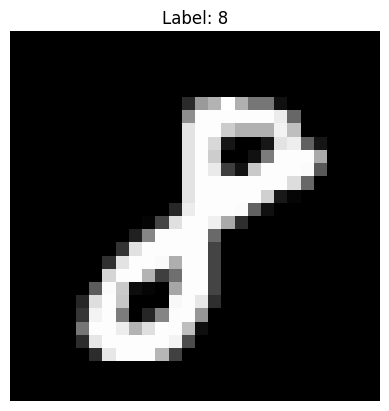

In [14]:
images, labels = next(iter(dataset_loader))

image = images[31]
label = labels[31]

# Convert the image to numpy for visualization (remove the channel dimension)
image_np = image.numpy().squeeze() 

# Plot the image
plt.imshow(image_np, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title(f"Label: {label.item()}")  
plt.axis('off')  # Turn off axis
plt.show()


In [15]:
def get_mean_std(data_loader):
    
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in (data_loader):
        
        channels_sum += torch.mean(data, dim=[0, 2, 3])  # Mean along batch and spatial dims
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])  # Mean of squared values
        num_batches += 1
    
    # Calculate the mean and std by averaging across all batches
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std


#### Neural networks generally perform best when the data has a mean of 0 and a standard deviation of 1.

In [16]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: tensor([0.1307])
Standard deviation: tensor([0.3081])


In [17]:
train_dataset, val_dataset = random_split(dataset,([0.8,0.2]))
print("Training data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))

Training data set size: 48000
Validation data set size: 12000


In [18]:
batch_size = 32

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

val_loader = DataLoader(val_dataset,batch_size=batch_size)

# Build Model

In [19]:
model = nn.Sequential()

In [20]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
model.append(conv1)
model.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
)

In [21]:
maxpool1= torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(maxpool1)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [22]:
second_conv=torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
second_pool=torch.nn.MaxPool2d(kernel_size=(2,2),stride=2)
model.append(second_conv)
model.append(torch.nn.ReLU())
model.append(second_pool)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [23]:
conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
model.append(conv3)
model.append(torch.nn.ReLU())
max_pool3 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(max_pool3)
model.append(torch.nn.Flatten())

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [24]:
model.append(torch.nn.Dropout())
model.append(torch.nn.Linear(in_features=576, out_features=500))  
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=576, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
)

In [25]:
model.append(torch.nn.Linear(in_features=500, out_features=10))

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=576, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=10, bias=True)
)

In [26]:
summary(model, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 10]                  --
├─Conv2d: 1-1                            [32, 16, 28, 28]          160
├─ReLU: 1-2                              [32, 16, 28, 28]          --
├─MaxPool2d: 1-3                         [32, 16, 14, 14]          --
├─Conv2d: 1-4                            [32, 32, 14, 14]          4,640
├─ReLU: 1-5                              [32, 32, 14, 14]          --
├─MaxPool2d: 1-6                         [32, 32, 7, 7]            --
├─Conv2d: 1-7                            [32, 64, 7, 7]            18,496
├─ReLU: 1-8                              [32, 64, 7, 7]            --
├─MaxPool2d: 1-9                         [32, 64, 3, 3]            --
├─Flatten: 1-10                          [32, 576]                 --
├─Dropout: 1-11                          [32, 576]                 --
├─Linear: 1-12                           [32, 500]                 288,500
├─

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to('cuda')

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=576, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=10, bias=True)
)

In [28]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        # Training loop
        for data, target in train_loader:
            data, target = data.to("cuda"), target.to("cuda")
            optimizer.zero_grad()  
            outputs = model(data)  # Forward pass
            loss = loss_fn(outputs, target)  # Compute loss
            loss.backward()  # Backward pass 
            optimizer.step()  # Update the weights
            
            running_loss += loss.item()
        
        # Compute the average loss for this epoch
        avg_loss = running_loss / len(train_loader)
        
        # Validation accuracy
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():  # No gradients for validation
            for data, target in val_loader:
                data, target = data.to("cuda"), target.to("cuda")
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)  # Get the predicted class
                total += target.size(0)  # Total number of samples
                correct += (predicted == target).sum().item()  # Correct predictions
        
        val_accuracy = correct / total * 100  # Calculate validation accuracy

        # Print the results
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


In [29]:
# Call the train function
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10)

Epoch 1/10, Loss: 0.2940, Validation Accuracy: 97.81%
Epoch 2/10, Loss: 0.1117, Validation Accuracy: 98.28%
Epoch 3/10, Loss: 0.0890, Validation Accuracy: 98.72%
Epoch 4/10, Loss: 0.0739, Validation Accuracy: 98.74%
Epoch 5/10, Loss: 0.0647, Validation Accuracy: 98.98%
Epoch 6/10, Loss: 0.0577, Validation Accuracy: 98.83%
Epoch 7/10, Loss: 0.0551, Validation Accuracy: 99.02%
Epoch 8/10, Loss: 0.0513, Validation Accuracy: 99.07%
Epoch 9/10, Loss: 0.0465, Validation Accuracy: 99.12%
Epoch 10/10, Loss: 0.0465, Validation Accuracy: 99.24%


# Model Prediction

In [30]:
dataset_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [31]:
print(len(dataset_test))

10000


In [32]:
test_dataloader= DataLoader(dataset_test,batch_size=32)

In [33]:
# Function to predict on the test dataset
def predict(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  
        for data, target in (test_loader):
            data, target = data.to(device), target.to(device)  
            
            # Make predictions
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)  
            
            # Store predictions and true labels
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the appropriate device (GPU or CPU)

predictions, true_labels = predict(model, test_dataloader, device)


print("Predictions: ", predictions[:10])
print("True Labels: ", true_labels[:10])


Predictions:  [7 2 1 0 4 1 4 9 5 9]
True Labels:  [7 2 1 0 4 1 4 9 5 9]


# Confusion Matrix

In [35]:
import seaborn as sns

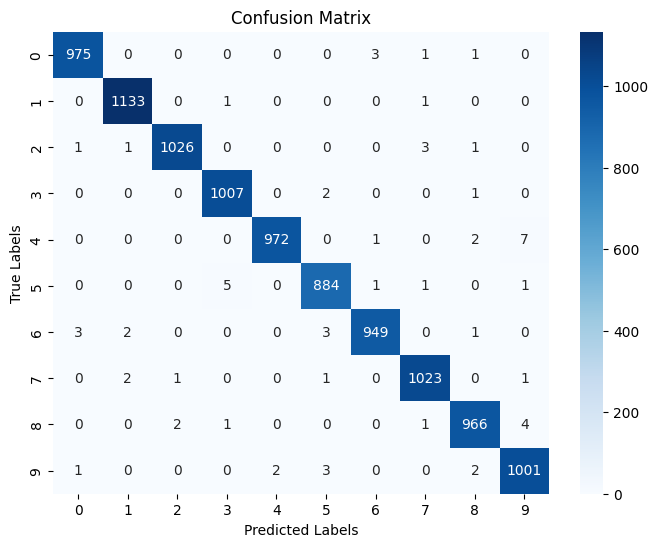

In [36]:
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()